In [1]:
import sys
sys.path.append('../')
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA as ARIMA_sm
from gtime.preprocessing import TimeSeriesPreparation
from gtime.time_series_models import ARIMA, AR
from sklearn.compose import make_column_selector
from gtime.feature_extraction import Shift
from sklearn.metrics import mean_squared_error
from scipy.stats import normaltest
from numpy.linalg import multi_dot
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from gtime.stat_tools.mle_estimate import _run_css, _run_mle
%matplotlib inline  
%load_ext Cython


## TIme series

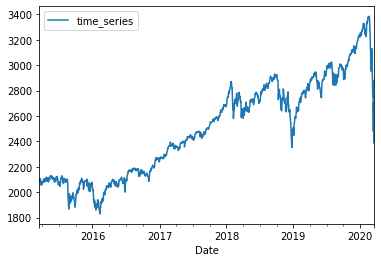

In [17]:
df_sp = pd.read_csv('https://storage.googleapis.com/l2f-open-models/giotto-time/examples/data/^GSPC.csv', parse_dates=['Date'])
df_close = df_sp.set_index('Date')['Close']
time_series_preparation = TimeSeriesPreparation()
df_real = time_series_preparation.transform(df_close)

df_real.plot();

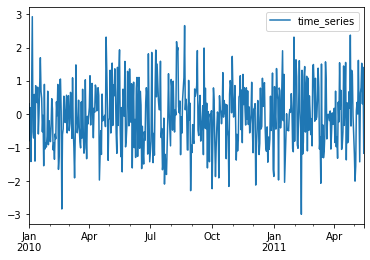

In [18]:
df_white = pd.DataFrame(np.random.standard_normal(500))
time_series_preparation = TimeSeriesPreparation(start='01-01-2010', freq='1D')
df_white = time_series_preparation.transform(df_white)

df_white.plot();

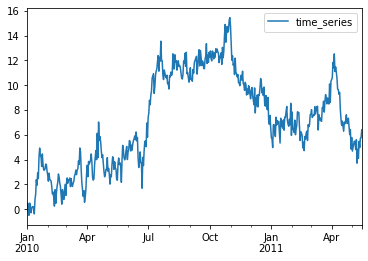

In [19]:
arm_np = np.zeros(501)
mean = 0.0
ar = -.4
ma = -.7
eps = np.random.standard_normal()
for i in range(1, 501):
    arm_np[i] = mean + ar * arm_np[i-1] + ma * eps
    eps = np.random.standard_normal()
arima_np = arm_np.cumsum()
df_arima = pd.DataFrame(arima_np)
time_series_preparation = TimeSeriesPreparation(start='01-01-2010', freq='1D')
df_arima = time_series_preparation.transform(df_arima)
df_arima.plot()

## Test functions

In [5]:
def train_test_plot(df_train, df_test, df_pred, train_error, test_error):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    df_train.plot(ax=ax[0])
    df_test.plot(ax=ax[0])
    df_pred.plot(ax=ax[0])
    ax[1].hist(train_error)
    ax[2].hist(test_error)

In [6]:
def run_giotto_ar(df, test_size, p):
    model = AR(horizon=test_size, p=p)
    df_train = df
    df_test = df.iloc[-test_size:]
    model = model.fit(df_train)
    pred_g = model.predict()
    y_pred = pd.DataFrame(pred_g.values[0], index=df_test.index, columns=['time_series'])
    print('Basic AR results results:')
    print(f'Fitted parameters: mu={model.model.estimators_[0].intercept_:.2f}, p={model.model.estimators_[0].coef_}')
    print(f'RMSE: {mean_squared_error(y_pred, df_test.values):.2f}\n')
    return model.model.estimators_[0].coef_

mar = run_giotto_ar(df_white, 100, 4)
mar

Basic AR results results:
Fitted parameters: mu=-0.00, p=[-0.07 -0.02 -0.04 -0.01]
RMSE: 1.19



array([-0.07, -0.02, -0.04, -0.01])

Giotto results css:
Fitted parameters: mu=-0.00, p=[-0.07 -0.02 -0.04 -0.01], q=[]
AR roots abs:[3.88 3.88 2.63 2.63]
MA roots abs:[]
Train error mean: -0.00, std: 0.96
LL: 544.50
RMSE: 1.20



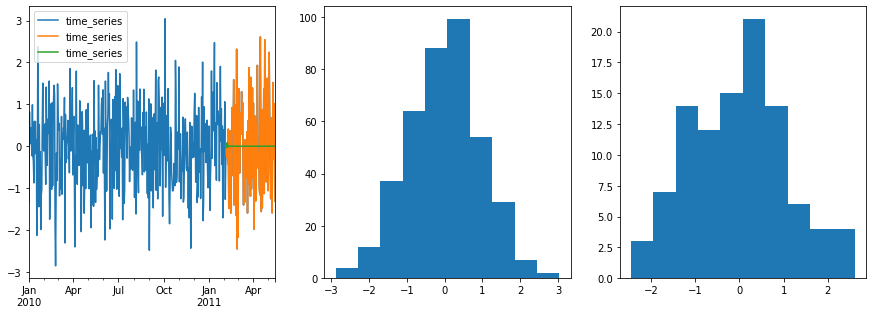

In [7]:
def run_giotto_arima(df, test_size, order, method='css-mle', plot=True):
    model = ARIMA(horizon=test_size, order=order, method=method)
    df_train = df
    df_test = df.iloc[-test_size:]
    model.fit(df_train)
    pred_g = model.predict(df_test.iloc[[0]])
    y_pred = pd.DataFrame(pred_g.values[0], index=df_test.index, columns=['time_series'])
    phi = model.model.phi_
    theta = model.model.theta_
    mu = model.model.mu_
    train_errors = model.model.errors_
    print(f'Giotto results {method}:')
    print(f'Fitted parameters: mu={mu:.2f}, p={phi}, q={theta}')
    print(f'AR roots abs:{np.abs(np.roots(np.r_[-phi[::-1], 1.0]))}')
    print(f'MA roots abs:{np.abs(np.roots(np.r_[theta[::-1], 1.0]))}')
    print(f'Train error mean: {train_errors.mean():.2f}, std: {train_errors.std():.2f}')
    print(f'LL: {model.model.model.ml:.2f}')
    print(f'RMSE: {mean_squared_error(y_pred, df_test.values):.2f}\n')
#     print(normaltest(train_errors))
    if plot:
        test_errors = df_test -  y_pred
        train_test_plot(df_train, df_test, y_pred, train_errors, test_errors.values)
    return mu, phi, theta
    
mu, phi, theta = run_giotto_arima(df_white, 100, (4, 0, 0), 'css')

Statsmodels results css:
Fitted parameters: mu=-0.00, p=[-0.07 -0.02 -0.04 -0.01], q=[]
AR roots abs:[2.63 2.63 3.88 3.88]
MA roots abs:[]
Train error mean: -0.00, std: 0.96
LL: 544.50
RMSE: 1.20



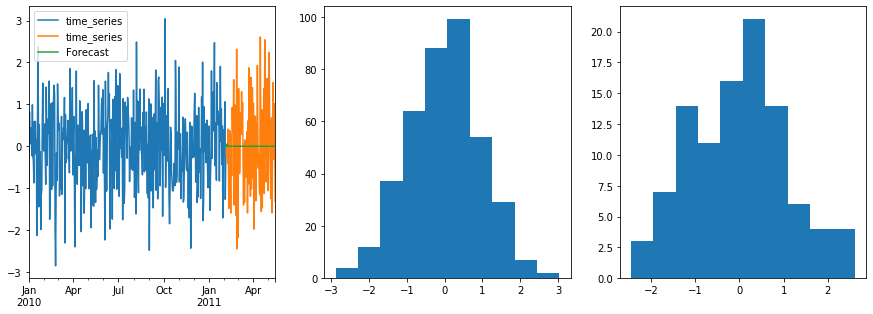

In [8]:
def run_sm(df, test_size, order, method='css-mle', plot=True):
    df_train = df.iloc[:-test_size]
    df_test = df.iloc[-test_size:]
    m2 = ARIMA_sm(df_train, order)
    f = m2.fit(method=method)
    y2, _, _ = f.forecast(test_size)
    y_pred = pd.DataFrame(y2, index=df_test.index, columns=['Forecast'])
    print(f'Statsmodels results {method}:')
    print(f'Fitted parameters: mu={f.params.const:.2f}, p={f.arparams}, q={f.maparams}')
    print(f'AR roots abs:{np.abs(f.arroots)}')
    print(f'MA roots abs:{np.abs(f.maroots)}')
    train_errors = m2.geterrors(f.params)
    print(f'Train error mean: {train_errors.mean():.2f}, std: {train_errors.std():.2f}')
    print(f'LL: {-f.llf:.2f}')
    print(f'RMSE: {mean_squared_error(y2, df_test.values):.2f}\n')
#     print(normaltest(train_errors))
    if plot:
        test_errors = df_test.values.flatten() -  y2
        train_test_plot(df_train, df_test, y_pred, train_errors, test_errors)
    return f, m2

f = run_sm(df_white, 100, (4, 0, 0), 'css')

## Simple AR check

In [12]:
df = df_white
run_giotto_ar(df, 100, 2)
run_sm(df, 100, (2, 0, 0), 'css', plot=False);
run_sm(df, 100, (2, 0, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'mle', plot=False);

Basic AR results results:
Fitted parameters: mu=0.01, p=[-0.03 -0.06]
RMSE: 0.90

Statsmodels results css:
Fitted parameters: mu=0.01, p=[-0.03 -0.06], q=[]
AR roots abs:[3.93 3.93]
MA roots abs:[]
Train error mean: 0.00, std: 1.02
RMSE: 0.89

Statsmodels results mle:
Fitted parameters: mu=0.02, p=[-0.02 -0.07], q=[]
AR roots abs:[3.92 3.92]
MA roots abs:[]
Train error mean: 0.00, std: 1.03
RMSE: 0.89

Giotto results css:
Fitted parameters: mu=0.01, p=[-0.03 -0.06], q=[]
AR roots abs:[3.93 3.93]
MA roots abs:[]
Train error mean: 0.00, std: 1.02
RMSE: 0.89



../gtime/stat_tools/tools.py:44: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=0.02, p=[-0.02 -0.07], q=[]
AR roots abs:[3.92 3.92]
MA roots abs:[]
Train error mean: -0.00, std: 1.03
RMSE: 0.89



In [13]:
df = df_real
run_giotto_ar(df, 100, 2)
run_sm(df, 100, (2, 0, 0), 'css', plot=False);
run_sm(df, 100, (2, 0, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'mle', plot=False);

Basic AR results results:
Fitted parameters: mu=3.58, p=[0.98 0.02]
RMSE: 44772.60

Statsmodels results css:
Fitted parameters: mu=3261.40, p=[0.98 0.02], q=[]
AR roots abs:[ 1.   49.74]
MA roots abs:[]
Train error mean: -0.02, std: 20.81
RMSE: 52639.91

Statsmodels results mle:
Fitted parameters: mu=2494.44, p=[0.98 0.02], q=[]
AR roots abs:[ 1.   53.84]
MA roots abs:[]
Train error mean: 0.37, std: 23.82
RMSE: 67607.63

Giotto results css:
Fitted parameters: mu=3147.93, p=[0.98 0.02], q=[]
AR roots abs:[50.01  1.  ]
MA roots abs:[]
Train error mean: -0.01, std: 20.81
RMSE: 53481.82



../gtime/stat_tools/tools.py:44: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=2442.22, p=[0.98 0.02], q=[]
AR roots abs:[46.71  1.  ]
MA roots abs:[]
Train error mean: 0.79, std: 20.80
RMSE: 54647.72



## Simple ARI check

In [11]:
df = df_white
run_sm(df, 100, (2, 1, 0), 'css', plot=False);
run_sm(df, 100, (2, 1, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.00, p=[-0.69 -0.34], q=[]
AR roots abs:[1.73 1.73]
MA roots abs:[]
Train error mean: 0.00, std: 1.15
LL: 619.73
RMSE: 1.30

Statsmodels results mle:
Fitted parameters: mu=0.00, p=[-0.69 -0.33], q=[]
AR roots abs:[1.73 1.73]
MA roots abs:[]
Train error mean: -0.00, std: 1.15
LL: 622.19
RMSE: 1.31

Giotto results css:
Fitted parameters: mu=-0.00, p=[-0.69 -0.34], q=[]
AR roots abs:[1.73 1.73]
MA roots abs:[]
Train error mean: -0.00, std: 1.15
LL: 618.15
RMSE: 1.44

Giotto results mle:
Fitted parameters: mu=0.00, p=[-0.69 -0.33], q=[]
AR roots abs:[1.73 1.73]
MA roots abs:[]
Train error mean: 0.00, std: 1.15
LL: 621.13
RMSE: 1.52



In [12]:
df = df_real
run_sm(df, 100, (2, 1, 0), 'css', plot=False);
run_sm(df, 100, (2, 1, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: 0.00, std: 20.78
LL: 5147.77
RMSE: 46983.52

Statsmodels results mle:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: 0.00, std: 20.77
LL: 5156.18
RMSE: 46931.59

Giotto results css:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.22 4.22]
MA roots abs:[]
Train error mean: 0.00, std: 20.79
LL: 5143.79
RMSE: 45117.28



../gtime/stat_tools/tools.py:44: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=0.78, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: -0.01, std: 20.77
LL: 5152.09
RMSE: 45023.85



In [14]:
df = df_arima
run_sm(df, 100, (1, 1, 0), 'css', plot=False);
run_sm(df, 100, (1, 1, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (1, 1, 0), 'css', plot=False);
run_giotto_arima(df, 100, (1, 1, 0), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.06, p=[-0.34], q=[]
AR roots abs:[2.9]
MA roots abs:[]
Train error mean: 0.00, std: 0.71
LL: 428.85
RMSE: 47.45

Statsmodels results mle:
Fitted parameters: mu=0.06, p=[-0.34], q=[]
AR roots abs:[2.91]
MA roots abs:[]
Train error mean: 0.00, std: 0.71
LL: 429.62
RMSE: 47.83

Giotto results css:
Fitted parameters: mu=0.06, p=[-0.34], q=[]
AR roots abs:[2.9]
MA roots abs:[]
Train error mean: 0.00, std: 0.71
LL: 428.24
RMSE: 57.48

Giotto results mle:
Fitted parameters: mu=0.06, p=[-0.34], q=[]
AR roots abs:[2.91]
MA roots abs:[]
Train error mean: -0.00, std: 0.71
LL: 428.88
RMSE: 57.53



## Full ARIMA check

In [15]:
df = df_white
run_sm(df, 100, (2, 1, 3), 'css', plot=False);
run_sm(df, 100, (2, 1, 3), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 1, 3), 'css', plot=False);
run_giotto_arima(df, 100, (2, 1, 3), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.00, p=[-1.13 -0.93], q=[ 0.16 -0.14 -0.96]
AR roots abs:[1.04 1.04]
MA roots abs:[1.01 1.01 1.02]
Train error mean: 0.03, std: 0.98
LL: 555.94
RMSE: 1.04



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
../gtime/stat_tools/mle_estimate.py:109: RuntimeWarning: invalid value encountered in double_scalars
  loglikelihood = -nobs / 2. * (np.log(2 * np.pi * sigma2)) - ssr / (2. * sigma2)


Statsmodels results mle:
Fitted parameters: mu=0.00, p=[-1.13 -0.95], q=[ 0.15 -0.15 -1.  ]
AR roots abs:[1.03 1.03]
MA roots abs:[1. 1. 1.]
Train error mean: 0.03, std: 0.97
LL: 555.52
RMSE: 1.05

Giotto results css:
Fitted parameters: mu=-0.00, p=[-0.86 -0.46], q=[-0.16 -0.37 -0.48]
AR roots abs:[1.47 1.47]
MA roots abs:[1.45 1.45 1.  ]
Train error mean: 0.00, std: 0.98
LL: 553.32
RMSE: 1.90



../gtime/stat_tools/tools.py:44: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=0.00, p=[0.   0.83], q=[-1.1  -0.77  0.87]
AR roots abs:[1.1  1.09]
MA roots abs:[1.13 1.01 1.01]
Train error mean: 0.02, std: 0.97
LL: 553.24
RMSE: 464.99



In [17]:
df = df_real
run_sm(df, 100, (4, 1, 3), 'css', plot=False);
run_sm(df, 100, (4, 1, 3), 'mle', plot=False);
run_giotto_arima(df, 100, (4, 1, 3), 'css', plot=False);
run_giotto_arima(df, 100, (4, 1, 3), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.80, p=[ 0.29  0.41 -0.46 -0.04], q=[-0.31 -0.45  0.5 ]
AR roots abs:[ 1.22  1.29  1.29 12.28]
MA roots abs:[1.15 1.31 1.31]
Train error mean: -0.00, std: 20.75
LL: 5136.88
RMSE: 46905.24

Statsmodels results mle:
Fitted parameters: mu=0.81, p=[ 0.38 -0.2   0.77 -0.02], q=[-0.4   0.15 -0.72]
AR roots abs:[ 1.03  1.13  1.13 38.81]
MA roots abs:[1.01 1.17 1.17]
Train error mean: -0.10, std: 20.68
LL: 5150.93
RMSE: 49264.60



../gtime/stat_tools/mle_estimate.py:109: RuntimeWarning: invalid value encountered in double_scalars
  loglikelihood = -nobs / 2. * (np.log(2 * np.pi * sigma2)) - ssr / (2. * sigma2)


Giotto results css:
Fitted parameters: mu=0.82, p=[-0.29  0.52 -0.01  0.  ], q=[ 0.27 -0.58  0.01]
AR roots abs:[17.71 17.71  1.71  1.13]
MA roots abs:[42.65  1.6   1.09]
Train error mean: 0.01, std: 20.74
LL: 5131.77
RMSE: 44562.98

Giotto results mle:
Fitted parameters: mu=0.78, p=[0.69 0.43 0.15 0.54], q=[0.09 0.49 0.57]
AR roots abs:[1.29 1.38 1.38 0.75]
MA roots abs:[1.52 1.08 1.08]
Train error mean: 2.99, std: 136.20
LL: 2042295.57
RMSE: 1863387196268472958976.00



In [16]:
df = df_arima
run_sm(df, 100, (2, 1, 3), 'css', plot=False);
run_sm(df, 100, (2, 1, 3), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 1, 3), 'css', plot=False);
run_giotto_arima(df, 100, (2, 1, 3), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.06, p=[-0.82  0.11], q=[ 0.5  -0.23  0.14]
AR roots abs:[1.06 8.49]
MA roots abs:[1.09 2.55 2.55]
Train error mean: -0.00, std: 0.71
LL: 426.91
RMSE: 46.56

Statsmodels results mle:
Fitted parameters: mu=0.06, p=[-0.87  0.07], q=[ 0.54 -0.2   0.13]
AR roots abs:[ 1.06 14.07]
MA roots abs:[1.09 2.65 2.65]
Train error mean: 0.00, std: 0.71
LL: 428.26
RMSE: 46.89



../gtime/stat_tools/mle_estimate.py:109: RuntimeWarning: invalid value encountered in double_scalars
  loglikelihood = -nobs / 2. * (np.log(2 * np.pi * sigma2)) - ssr / (2. * sigma2)


Giotto results css:
Fitted parameters: mu=0.06, p=[-0.87  0.07], q=[ 0.54 -0.2   0.13]
AR roots abs:[14.1   1.06]
MA roots abs:[2.65 2.65 1.09]
Train error mean: 0.00, std: 0.71
LL: 426.28
RMSE: 51.69



../gtime/stat_tools/tools.py:44: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=-11.33, p=[0.08 0.92], q=[-0.26 -0.73 -0.01]
AR roots abs:[1.09 1.  ]
MA roots abs:[55.52  1.38  1.  ]
Train error mean: -0.00, std: 0.74
LL: 449.22
RMSE: 6187.89



## Performance tests

In [2]:
def mat_square(q: np.array, x: np.array):

    return np.linalg.multi_dot([x, q, np.transpose(x)])

def ll_np(nu: np.array, F: np.array):
    return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))

In [3]:
def alt_llf(nu, F):
    return -0.5 * (np.log(2 * np.pi * np.abs(F)) + nu * nu / F)

In [4]:
F = 420.0
nu = 35.1

F_n = np.array([[F]])
nu_n = np.array([[nu]])

In [167]:
%timeit alt_llf(nu, F)

2.8 µs ± 135 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [128]:
alt_llf(nu, F)

NameError: name 'alt_llf' is not defined

In [12]:
llf_so(nu, F)

-5.405744460271951

In [125]:
%timeit llf_so(nu, F)

102 ns ± 1.73 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [126]:
%timeit llf_c(nu, F)

107 ns ± 8.18 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [112]:
from setuptools import setup
from Cython.Build import cythonize

setup(
    name='Loglikelihood function',
    ext_modules=cythonize("loglike.pyx"),
    zip_safe=False,
)

Compiling loglike.pyx because it changed.
[1/1] Cythonizing loglike.pyx


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/semyonburyachenko/Documents/Upwork/Giotto/giotto-time/examples/loglike.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


SystemExit: usage: ipykernel_launcher.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
   or: ipykernel_launcher.py --help [cmd1 cmd2 ...]
   or: ipykernel_launcher.py --help-commands
   or: ipykernel_launcher.py cmd --help

error: option -f not recognized

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [9]:
from loglike import llf_c as llf_so

In [8]:
! python3 setup.py build_ext --inplace

running build_ext
copying build/lib.macosx-10.9-x86_64-3.7/loglike.cpython-37m-darwin.so -> 


In [165]:
%%cython -a
from libc.math cimport log, M_PI

def llf_c(double nu, double F):
    return llf_cp(nu,  F)

cdef double llf_cp(double nu, double F):
    return -0.5 * (log(2 * M_PI * abs(F)) + nu * nu / F)


In [33]:
q = toeplitz(range(5))
x = np.random.random((5, 5))
x = np.array(x, order='F')
q = np.array(q, dtype=float, order='F')
res = x.copy()
res = np.array(res, order='F')

In [173]:
%timeit mat_square(q, x)

5.83 µs ± 660 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [36]:
mat_square_ct(x, q, 5)

array([[13.2 ,  8.49, 18.9 , 13.58, 13.66],
       [ 8.49,  5.01, 11.58,  7.72,  8.63],
       [18.9 , 11.58, 26.25, 18.33, 19.34],
       [13.58,  7.72, 18.33, 11.17, 13.64],
       [13.66,  8.63, 19.34, 13.64, 13.65]])

In [37]:
%timeit mat_square_ct(q, x, 5)

4.98 µs ± 78.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [38]:
%timeit mat_square(q, x)

5.15 µs ± 116 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [182]:
q

array([[0., 1., 2., 3., 4.],
       [1., 0., 1., 2., 3.],
       [2., 1., 0., 1., 2.],
       [3., 2., 1., 0., 1.],
       [4., 3., 2., 1., 0.]])

In [181]:
cholesky(q)

LinAlgError: 1-th leading minor of the array is not positive definite

In [283]:
def alt_likelihood_old(X, mu, sigma, phi, theta, errors=False):

    m = len(phi)
    R = np.array([np.r_[1.0, theta[:-1]]]).T
    K = np.concatenate((phi[:-1].reshape((-1, 1)), np.identity(m - 1)), axis=1)
    K = np.concatenate((K, np.concatenate((phi[-1:], np.zeros(m - 1))).reshape(1, -1)))
    Q = np.array([[sigma ** 2]])
    Z = np.zeros((1, m))
    Z[0, 0] = 1.0
    eps = np.zeros(len(X))
    vec_RR = np.matmul(R, R.T).ravel()
    vec_K = np.linalg.inv(np.identity(m ** 2) - np.kron(K, K))
    p = sigma ** 2 * np.matmul(vec_K, vec_RR).reshape((m, m))
    a = np.zeros((m, 1))
    x_hat = a[0] + mu
    nu = float(X[0] - x_hat)
    F = p[0, 0]

    p_hat = p
    a_hat = a
    
    LL_last = -0.5 * (np.log(2 * np.pi * np.abs(F)) + nu * nu / F)
    loglikelihood = LL_last
    eps[0] = nu
    rqr = mat_square(Q, R)
#     print(K)
    for i, x in enumerate(X[1:]):
        
#         print('A0', '\t'.join(map(str, a_hat.flatten())))
        pz = p_hat[:, [0]]
        gain = pz / F
#         print('\t'.join(map(str, (gain * nu).flatten())))
        a = a_hat + gain * nu
        p = p_hat - np.dot(gain, pz.T)
#         print('A1', '\t'.join(map(str, a.flatten())))
        
        a_hat = np.matmul(K, a)
        p_hat = mat_square(p, K) + rqr
        x_hat = a_hat[0] + mu
        F = p_hat[0, 0]
#         print('A2', '\t'.join(map(str, a_hat.flatten())))
#         print('\t'.join(map(str, a.flatten())))

        nu = float(x - x_hat)
        eps[i] = nu
        LL_last = -0.5 * (np.log(2 * np.pi * np.abs(F)) + nu * nu / F)
        loglikelihood += LL_last
    return loglikelihood, eps

In [230]:
from statsmodels.tsa.kalmanf import kalman_loglike
def alt_likelihood_sm(X, mu, sigma, phi, theta, errors=False):

    m = len(phi)
    R = np.array([np.r_[1.0, theta[:-1]]]).T
    K = np.concatenate((phi[:-1].reshape((-1, 1)), np.identity(m - 1)), axis=1)
    K = np.concatenate((K, np.concatenate((phi[-1:], np.zeros(m - 1))).reshape(1, -1)))
    Q = np.array([[sigma ** 2]])
    Z = np.zeros((1, m))
    Z[0, 0] = 1.0
    eps = np.zeros(len(X))
    vec_RR = np.matmul(R, R.T).ravel()
    vec_K = np.linalg.inv(np.identity(m ** 2) - np.kron(K, K))
    p = sigma ** 2 * np.matmul(vec_K, vec_RR).reshape((m, m))
    a = np.zeros(m)
    x_hat = a[0] + mu
    nu = float(X[0] - x_hat)
    F = p[0, 0]

    p = np.array(p, order='F')
    K = np.array(K, order='F')
    
    LL_last = -0.5 * (np.log(2 * np.pi * np.abs(F)) + nu * nu / F)
    loglikelihood = LL_last
    eps[0] = nu
    rqr = mat_square(Q, R)
    rqr = np.array(rqr, order='F')
    r = p.shape[0]
    n = len(X)
    eps, fs, ll = kalman_loglike.kalman_filter_double(X, 1, len(phi), len(theta), r, n, Z, R, K)
    llh, s = kalman_loglike.kalman_loglike_double(X, 1, len(phi), len(theta), r, n, Z, R, K)
    loglikelihood += ll
    return ll, eps, fs, llh, s

In [87]:
def alt_likelihood(X, mu, sigma, phi, theta, errors=False):

    m = len(phi)
    R = np.array([np.r_[1.0, theta[:-1]]]).T
    K = np.concatenate((phi[:-1].reshape((-1, 1)), np.identity(m - 1)), axis=1)
    K = np.concatenate((K, np.concatenate((phi[-1:], np.zeros(m - 1))).reshape(1, -1)))
    Q = np.array([[sigma ** 2]])
    Z = np.zeros((1, m))
    Z[0, 0] = 1.0
    eps = np.zeros(len(X))
    vec_RR = np.matmul(R, R.T).ravel()
    vec_K = np.linalg.inv(np.identity(m ** 2) - np.kron(K, K))
    p = sigma ** 2 * np.matmul(vec_K, vec_RR).reshape((m, m))
    a = np.zeros(m)
    x_hat = a[0] + mu
    nu = float(X[0] - x_hat)
    F = p[0, 0]

    p = np.array(p, order='F')
    K = np.array(K, order='F')
    
    LL_last = -0.5 * (np.log(2 * np.pi * np.abs(F)) + nu * nu / F)
    loglikelihood = LL_last
    eps[0] = nu
    rqr = mat_square(Q, R)
    rqr = np.array(rqr, order='F')
    r = p.shape[0]
    n = len(X)
    ll, eps = roll(X, a, p, eps, mu, F, nu, rqr, K, r, n)
    return loglikelihood + ll, eps

In [234]:
x = df_real.values.flatten()
x -= x.mean()
phi = np.array([0.3, 0.2])
theta = np.array([0.1, 0.0])

In [239]:
pd.DataFrame(eps.flatten()).to_clipboard()

In [306]:
pd.DataFrame(np.array(eps)).to_clipboard()

In [240]:
pd.DataFrame(np.array(f)).to_clipboard()

In [249]:
nobs = len(x)
sigma2 = 1. / nobs * sum(eps**2 / f)
loglike = -.5 * (ll + nobs * np.log(sigma2))
print(loglike)
loglike -= nobs / 2. * (np.log(2 * np.pi) + 1)
loglike

[-6489.4]


array([-8275.84])

In [324]:
ll

-8275.843571044968

In [235]:
ll , eps, f, llh, s = alt_likelihood_sm(x, 0.0, 20.0, phi, theta)

In [313]:
np.sqrt(s)

173.17209674832844

In [252]:
ll, eps = alt_likelihood_old(x, 0, 20.0, phi, theta)

[[0.3 1. ]
 [0.2 0. ]]
A0 0.0	0.0
A1 -398.6520235901512	-67.78921507132063
A2 -187.38482214836597	-79.73040471803024
A0 -187.38482214836597	-79.73040471803024
A1 -408.88200359015127	-101.34879529053433
A2 -224.0133963675797	-81.77640071803026
A0 -224.0133963675797	-81.77640071803026
A1 -390.0519255901513	-98.37627166224982
A2 -215.39184933929522	-78.01038511803027
A0 -215.39184933929522	-78.01038511803027
A1 -393.73210159015116	-95.8443675732077
A2 -213.96399805025305	-78.74642031803023
A0 -213.96399805025305	-78.74642031803023
A1 -406.6520235901512	-98.01522240991187
A2 -220.01082948695722	-81.33040471803025
A0 -220.01082948695722	-81.33040471803025
A1 -437.10197459015126	-103.03951922314333
A2 -234.1701116001887	-87.42039491803025
A0 -234.1701116001887	-87.42039491803025
A1 -442.0021215901511	-108.20359591697665
A2 -240.804232394022	-88.40042431803022
A0 -240.804232394022	-88.40042431803022
A1 -437.13200359015127	-108.03320143764267
A2 -239.17280251468804	-87.42640071803027
A0 -239.1

A1 -448.57194559015124	-111.2340796662675
A2 -245.80566334331286	-89.71438911803025
A0 -245.80566334331286	-89.71438911803025
A1 -446.5519255901513	-109.7890153427141
A2 -243.75459301975948	-89.31038511803027
A0 -243.75459301975948	-89.31038511803027
A1 -448.35197459015126	-109.77012327506945
A2 -244.2757156521148	-89.67039491803025
A0 -244.2757156521148	-89.67039491803025
A1 -461.4420625901512	-111.3870296118339
A2 -249.81964838887924	-92.28841251803024
A0 -249.81964838887924	-92.28841251803024
A1 -462.2120825901511	-113.52765593815744
A2 -252.19128071520277	-92.44241651803023
A0 -252.19128071520277	-92.44241651803023
A1 -461.10197459015126	-113.33348590552508
A2 -251.66407828257047	-92.22039491803025
A0 -251.66407828257047	-92.22039491803025
A1 -443.14201359015124	-111.36818844878833
A2 -244.31079252583368	-88.62840271803026
A0 -244.31079252583368	-88.62840271803026
A1 -434.20207259015115	-107.617530724462
A2 -237.87815250150734	-86.84041451803023
A0 -237.87815250150734	-86.840414518

A2 -160.6957382276003	-58.698422318030225
A0 -160.6957382276003	-58.698422318030225
A1 -299.3419645901513	-72.56304495428533
A2 -162.3656343313307	-59.86839291803026
A0 -162.3656343313307	-59.86839291803026
A1 -307.07194559015124	-74.33902404391232
A2 -166.46060772095768	-61.41438911803025
A0 -166.46060772095768	-61.41438911803025
A1 -306.20207259015115	-75.3885356049496
A2 -167.24915738199493	-61.240414518030235
A0 -167.24915738199493	-61.240414518030235
A1 -293.4420625901512	-73.85970503884586
A2 -161.89232381589122	-58.68841251803024
A0 -161.89232381589122	-58.68841251803024
A1 -285.92204359015113	-71.09138449545623
A2 -156.86799757250157	-57.18440871803023
A0 -156.86799757250157	-57.18440871803023
A1 -256.8019255901513	-67.1778015197952
A2 -144.2183791968406	-51.360385118030266
A0 -144.2183791968406	-51.360385118030266
A1 -251.9620825901511	-62.134755457361315
A2 -137.72338023440665	-50.392416518030224
A0 -137.72338023440665	-50.392416518030224
A1 -238.6219945901512	-60.48227795360

A2 48.63949194594324	17.29361868196984
A0 48.63949194594324	17.29361868196984
A1 84.14802540984874	20.84447202836039
A2 46.08887965131501	16.82960508196975
A0 46.08887965131501	16.82960508196975
A1 86.68806440984872	20.88952355782312
A2 46.89594288077774	17.337612881969743
A0 46.89594288077774	17.337612881969743
A1 80.71809340984919	20.71982793487689
A2 44.93525595783164	16.143618681969837
A0 44.93525595783164	16.143618681969837
A1 66.46809340984919	18.29690242717159
A2 38.23733045012635	13.29361868196984
A0 38.23733045012635	13.29361868196984
A1 87.48786940984883	18.218672577942087
A2 44.46503340089673	17.497573881969767
A0 44.46503340089673	17.497573881969767
A1 80.69807440984869	21.120877982864965
A2 45.33030030581957	16.139614881969738
A0 45.33030030581957	16.139614881969738
A1 83.98786940984883	20.005371792372664
A2 45.201732615327316	16.797573881969765
A0 45.201732615327316	16.797573881969765
A1 100.87800540984881	22.365201161421915
A2 52.628602784376554	20.175601081969763
A0 52.

A2 163.9445284247297	63.14757388196977
A0 163.9445284247297	63.14757388196977
A1 308.67805440984876	77.62092648048167
A2 170.2243428034363	61.735610881969755
A0 170.2243428034363	61.735610881969755
A1 282.85798640984876	72.99897524261101
A2 157.85637116556563	56.57159728196976
A0 157.85637116556563	56.57159728196976
A1 228.06794740984878	63.59275490639807
A2 132.0131391293527	45.61358948196976
A0 132.0131391293527	45.61358948196976
A1 224.0279084098488	54.81506641001937
A2 122.023438932974	44.80558168196976
A0 122.023438932974	44.80558168196976
A1 203.42805440984876	52.946043229657235
A2 113.97445955261186	40.68561088196975
A0 113.97445955261186	40.68561088196975
A1 232.04792740984885	52.49295766769345
A2 122.1073358906481	46.40958548196977
A0 122.1073358906481	46.40958548196977
A1 238.11799640984873	58.010651533889835
A2 129.44605045684446	47.623599281969746
A0 129.44605045684446	47.623599281969746
A1 192.57795640984887	53.936789877270186
A2 111.71017680022484	38.515591281969776
A0 11

A2 315.23591136821926	115.72560108196977
A0 315.23591136821926	115.72560108196977
A1 587.0279084098488	142.90480078613274
A2 319.0131733090874	117.40558168196976
A0 319.0131733090874	117.40558168196976
A1 594.9280544098488	144.9970697920459
A2 323.47548611500054	118.98561088196976
A0 323.47548611500054	118.98561088196976
A1 588.8579864098488	145.5238609114546
A2 322.1812568344092	117.77159728196976
A0 322.1812568344092	117.77159728196976
A1 593.6880644098487	144.9222780395137
A2 323.02869736246834	118.73761288196975
A0 323.02869736246834	118.73761288196975
A1 595.8880154098488	146.0235446867078
A2 324.78994930966246	119.17760308196976
A0 324.78994930966246	119.17760308196976
A1 598.4778594098484	146.54639409198836
A2 326.0897519149429	119.69557188196968
A0 326.0897519149429	119.69557188196968
A1 622.3079374098488	149.31739043146027
A2 336.0097716544149	124.46158748196977
A0 336.0097716544149	124.46158748196977
A1 623.8780054098488	153.24841085751316
A2 340.4118124804678	124.77560108196

In [323]:
ll, eps = alt_likelihood(x, 0.0, np.sqrt(s), phi, theta)

29988.575092212428 -221.49718144178527
-6.891219285774218
29988.575092212428 -165.50720165089717
-6.529942240737634
29988.575092212428 -178.3894030299858
-6.603806125591477
29988.575092212428 -192.683067692077
-6.692239561417045
29988.575092212428 -217.09164042586798
-6.859003332900176
29988.575092212428 -207.8319604524887
-6.793400740159928
29988.575092212428 -196.32777614982683
-6.715879082607153
29988.575092212428 -172.7392305800929
-6.5707279062047315
29988.575092212428 -201.9881967370663
-6.753470664171507
29988.575092212428 -206.8022170213689
-6.786281915419863
29988.575092212428 -192.92078999293872
-6.693767920733688
29988.575092212428 -181.18979229578133
-6.620595214697867
29988.575092212428 -192.20498186549764
-6.689171567676972
29988.575092212428 -186.9786584085258
-6.65613004523767
29988.575092212428 -179.03420015422302
-6.607648684145176
29988.575092212428 -172.84649277965343
-6.57134594632018
29988.575092212428 -188.21543461711022
-6.66386684377559
29988.575092212428 -182.

29988.575092212428 -143.27911799331775
-6.415503189794697
29988.575092212428 -154.2401897957438
-6.469876071554771
29988.575092212428 -142.7769444155012
-6.413108114405581
29988.575092212428 -151.8613304535254
-6.457735240273639
29988.575092212428 -150.25994654972308
-6.449668632432127
29988.575092212428 -151.91991474010337
-6.458031966734811
29988.575092212428 -147.63397112106534
-6.436625963586664
29988.575092212428 -145.04654998296917
-6.423999692336946
29988.575092212428 -149.8233099967787
-6.447484011816911
29988.575092212428 -163.03569779539768
-6.516403834191447
29988.575092212428 -150.25942931553584
-6.449666040796902
29988.575092212428 -150.343086363522
-6.450085325791298
29988.575092212428 -133.204593958723
-6.369061473363192
29988.575092212428 -142.57669449920337
-6.412155384205293
29988.575092212428 -143.91934364515532
-6.418568887677037
29988.575092212428 -149.89406303056006
-6.44783757835606
29988.575092212428 -137.29156149201964
-6.387493642977943
29988.575092212428 -142

29988.575092212428 40.59918475853371
-6.1007064415025685
29988.575092212428 33.82215052907145
-6.092297306772167
29988.575092212428 21.532837452017546
-6.080955074345578
29988.575092212428 49.250538959722476
-6.113666740255933
29988.575092212428 36.23304100895196
-6.0951133024276105
29988.575092212428 38.65756910402926
-6.098140695154975
29988.575092212428 55.676272794521495
-6.124908217425049
29988.575092212428 46.2994516254722
-6.108965343705137
29988.575092212428 49.78393584237723
-6.1145474870065275
29988.575092212428 47.223524420686715
-6.110406259747763
29988.575092212428 72.33171376285568
-6.160455579329139
29988.575092212428 61.36488872863882
-6.136009148602022
29988.575092212428 79.13854913206048
-6.177646011680219
29988.575092212428 65.74206729171836
-6.145285512040428
29988.575092212428 61.607715575752664
-6.136507022370496
29988.575092212428 54.057308147349104
-6.121946176254266
29988.575092212428 58.029268790189406
-6.12936906098316
29988.575092212428 67.40602172590555
-6.

29988.575092212428 142.4885925789062
-6.4117366447499435
29988.575092212428 154.4271305470338
-6.470838146288001
29988.575092212428 159.98122615022106
-6.49995346880946
29988.575092212428 153.11795528990223
-6.464125082803123
29988.575092212428 143.48316407593424
-6.416478773331401
29988.575092212428 177.67254719733057
-6.59955042012661
29988.575092212428 112.55673358519147
-6.284455159779819
29988.575092212428 126.83945694640528
-6.341464029867467
29988.575092212428 157.04997921028388
-6.484459288980641
29988.575092212428 135.3790975838964
-6.378799118601854
29988.575092212428 147.5229921465347
-6.436079818646328
29988.575092212428 164.86558529027093
-6.526408018378698
29988.575092212428 188.21941187589735
-6.663891806262077
29988.575092212428 172.30507431733463
-6.568230235917969
29988.575092212428 173.48339757319098
-6.575023666362443
29988.575092212428 177.49757284760528
-6.59851426451392
29988.575092212428 187.41727262016389
-6.658868010873311
29988.575092212428 184.25230534290793

In [327]:
%timeit alt_likelihood_sm(x, 0.0, np.sqrt(s), phi, theta)

844 µs ± 26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [288]:
%timeit alt_likelihood_old(x, 0.0, np.sqrt(s), phi, theta)

36.6 ms ± 909 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [326]:
%timeit alt_likelihood(x, 0.0, np.sqrt(s), phi, theta)

249 µs ± 15.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [325]:
%%cython -a
from scipy.linalg.cython_blas cimport dsymm, dgemm, dgemv, daxpy, dsyr, dcopy
from scipy.linalg.cython_lapack cimport dpotrf
from numpy cimport NPY_DOUBLE, npy_intp, PyArray_ZEROS, import_array, float64_t, ndarray
from numpy import zeros_like
from libc.math cimport log, M_PI

import_array()


cdef double llf_cp(double nu, double F):
    return -0.5 * (log(2 * M_PI * abs(F)) + nu * nu / F)


cdef void add_mat(double[::1, :] a, double[::1, :] b, int r, int c):
    
    cdef int i = 0
    cdef int j = 0
    
    for i in range(r):
        for j in range(c):
            a[i, j] = a[i, j] + b[i, j]
    

cdef void mat_square_c(double[::1, :] x, double[::1, :] q, int n):
    cdef int ldt = x.strides[1] // sizeof(float64_t)
    cdef double one = 1.0
    cdef double zero = 0.0
    cdef npy_intp r2shape[2] 
    r2shape[0] = <npy_intp> n
    r2shape[1] = <npy_intp> n
    cdef double[::1, :] res = PyArray_ZEROS(2, r2shape, NPY_DOUBLE, 1)
    dsymm('R', 'U', &n, &n, &one, &q[0, 0], &ldt, &x[0, 0], &ldt, &zero, &res[0, 0], &ldt)
    dgemm("N", "T", &n, &n, &n, &one, &res[0, 0], &ldt, &x[0, 0], &ldt, &zero, &x[0, 0], &ldt)


def roll(double[::1] x, double[::1] a, double[::1, :] p, double[::1] eps,
            double mu, double F, double nu,
            double[::1, :] rqr, double[::1, :] K,
           int r, int n):
    
    cdef int lda = a.strides[0] // sizeof(float64_t)
    cdef int ldk = K.strides[1] // sizeof(float64_t)
    cdef int ldp = p.strides[1] // sizeof(float64_t)
    cdef double one = 1.0
    cdef double zero = 0.0
    cdef double F_c = F
    cdef float64_t F_inv
    cdef float64_t nf
    cdef float64_t loglikelihood = 0.0
    cdef bint converged = False
    cdef int i = 0
    cdef double[::1] a_t = zeros_like(a, order='F')
    
    # for i, x in enumerate(X[1:]):
    for i in range(n-1):
         
        if F_c == rqr[0, 0]:
            converged = True
        
        F_inv = -1.0 / F_c
        nf = -nu * F_inv

        if converged:
            # a = a + p[:, 0] * nu / F
            # a = np.matmul(K, a)
            daxpy(&r, &nf, &p[0, 0], &ldp, &a[0], &lda)
            dgemv('N', &r, &r, &one, &K[0, 0], &ldk, &a[0], &lda, &zero, &a_t[0], &lda)
            dcopy(&r, &a_t[0], &lda, &a[0], &lda)
            
        else:
            # a = a + p[:, 0] * nu / F
            # p = p - np.dot(gain, pz.T)

            daxpy(&r, &nf, &p[0, 0], &ldp, &a[0], &lda)
            dsyr('L', &r, &F_inv, &p[0, 0], &ldp, &p[0, 0], &r)

            # a = np.matmul(K, a)
            # p = mat_square(p, K) + rqr
            # F = p[0, 0]

            dgemv('N', &r, &r, &one, &K[0, 0], &ldk, &a[0], &lda, &zero, &a_t[0], &lda)
            dcopy(&r, &a_t[0], &lda, &a[0], &lda)
            mat_square_c(p, K, r)
            add_mat(p, rqr, r, r)
            F_c = p[0, 0]

        nu = x[i+1] - a[0] - mu
        eps[i+1] = nu
        ll_last = llf_cp(nu, F_c)
        loglikelihood = loglikelihood + ll_last
    
    return loglikelihood, eps
    

In [1]:
import sys
sys.path.append('../')
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA as ARIMA_sm
from gtime.preprocessing import TimeSeriesPreparation
from gtime.time_series_models import ARIMA, AR
from sklearn.compose import make_column_selector
from gtime.feature_extraction import Shift
from sklearn.metrics import mean_squared_error
from scipy.stats import normaltest
from numpy.linalg import multi_dot
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from gtime.stat_tools.mle_estimate import _run_css, _run_mle
%matplotlib inline  
%load_ext Cython

In [2]:
F = 400.0
nu = 50.0
F_n = np.array([[F]])
nu_n = np.array([[nu]])
# a_hat = np.array([[-43.5], [-33.2], [-10.7]])
a_hat = np.array([-43.5, -33.2, -10.7])
p_hat = np.array([[443.5, 238.0, 110.2], [238.0, 57.2, 11.3], [110.2, 11.3, 117.0]], order='F')

In [15]:
def update_alt(a_hat, p_hat, F, nu):
    pz = p_hat[[0], :]
    gain = pz / F
    a = a_hat + gain * nu
#     print(np.dot(pz.T, pz) / F)
#     print(p_hat)
    p = p_hat - np.dot(pz.T, pz) / F
    return a, p

In [22]:
%%cython -a
from scipy.linalg.cython_blas cimport dsyr, daxpy, dscal, dcopy
cimport cython
from numpy cimport NPY_DOUBLE, npy_intp, PyArray_ZEROS, import_array, float64_t, ndarray
from numpy import array
from libc.stdio cimport printf


import_array()

@cython.boundscheck(False)
@cython.wraparound(False)
# @cython.cdivision(True)
# def update_cp(double[::1] a_hat, double[::1, :] p_hat, double F, float64_t nu, int r):
#     return update_c(a_hat, p_hat, F, nu, r)


def update_c(double[::1] a_hat, double[::1, :] p_hat, double F, double nu, int r):
    cdef int ldt = a_hat.strides[0] // sizeof(float64_t)
    cdef int ldp = p_hat.strides[1] // sizeof(float64_t)
    cdef int dimone = 1
    cdef double neg_one = -1.0
    cdef double zero = 0.0
#     cdef double[::1, :] pz = p_hat[0, :]

#     cdef npy_intp r2shape[2] 
#     r2shape[0] = <npy_intp> 1
#     r2shape[1] = <npy_intp> r
#     cdef double[::1] res = PyArray_ZEROS(1, &r, NPY_DOUBLE, 1)
#     dcopy(&r, &p_hat[0, 0], &ldt, &res[0], &ldt)
#     cdef int ldr = res.strides[0] // sizeof(float64_t)
#     print(array(res))
    
    cdef float64_t F_inv = -1.0 / F
    cdef float64_t nf = -nu * F_inv
#     print(array(pz))
#     print(array(p_hat))
#     print(F_inv)
#     print(nf)
#     print(ldt)
#     print(ldr)
#     print(ldp)
    daxpy(&r, &nf, &p_hat[0, 0], &ldp, &a_hat[0], &ldt)
#     dscal(&r, &F, &pz[0], &ldr)
#     print(array(pz))
    
    dsyr('L', &r, &F_inv, &p_hat[0, 0], &ldp, &p_hat[0, 0], &r)

#     dscal(&r, &F_inv, &pz[0], &ldt) 
#     dgemm("N", "N", &r, &r, &r, &one, &pz[0], &ldt, &pz2[0], &ldt, &zero, &p_hat[0, 0], &ldt)

    return a_hat, p_hat

In [5]:
update_c(a_hat, p_hat, F, nu, 3)

(<MemoryView of 'ndarray' at 0x11db33048>,
 <MemoryView of 'ndarray' at 0x11dd6d398>,
 <MemoryView of 'ndarray' at 0x11dd6d6e8>)

In [25]:
%timeit update_c(a_hat, p_hat, F, nu, len(a_hat))

1.94 µs ± 22.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [26]:
%timeit update_alt(a_hat, p_hat, F, nu)

10 µs ± 32.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [24]:
F = 400.0
nu = 50.0
F_n = np.array([[F]])
nu_n = np.array([[nu]])
# a_hat = np.array([[-43.5], [-33.2], [-10.7]])
a_hat = np.array([-43.5, -33.2, -10.7])
p_hat = np.array([[443.5, 238.0, 110.2], [238.0, 57.2, 11.3], [110.2, 11.3, 117.0]], order='F')

In [255]:
%timeit update_alt(a_hat, p_hat, F, nu)

10.2 µs ± 488 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [249]:
%timeit [np.array(x) for x in update_c(a_hat, p_hat, F, nu, len(a_hat))]

4.2 µs ± 42.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
